In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Naïve Bayes

## Intro

In statistics, we were introduced to Bayes' Theorem:

$P(A|B) = \frac{P(B | A)P(A)}{P(B)}$

The Bayes' Theorem allows us to discover the conditional probability $P(A|B)$, which is called the **posterior**, based on the inverse conditional probability, $P(B|A)$ (the so-called **likelihood**), and the probability $P(A)$, the **priori**. The idea is that we **update our beliefs about $A$**, as new information about $B$ is added.

## Naïve Bayes

Naïve Bayes is one of the simplest and most intuitive methods for classification, although it is full of important subtleties. For this reason, we will first build the idea of the method, apply it, and only then worry about its more mathematical details.

One of the main and most successful applications of this method is in **spam filtering**: given an email, how to determine if it is spam or not?

<img src=https://repository-images.githubusercontent.com/218616244/c4183680-fb99-11e9-8191-d7c5dfb6a11e width=500>

In [2]:
train_spam = ['type your password', 'type your password here', 'discount coupon here',
              'send password and get discount coupon', 'click here won discount',
              'discount coupon and password', 'discount password',
              'your password here', 'you won click here']

train_ham = ['attached report', 'attached budget', 'report attached',
              'meeting agenda attached', 'report today', 'budget report',
              'report attached', 'meeting agenda', 'meeting agenda attached']

df_train = pd.DataFrame([["spam", x] for x in train_spam] + [["ham", x] for x in train_ham],
                        columns = ["y", "excerpt"])
df_train.head()

,y,excerpt
0,spam,type your password
1,spam,type your password here
2,spam,discount coupon here
3,spam,send password and get discount coupon
4,spam,click here won discount


In [3]:
test_spam = ['type your password here', 'discount coupon here']
test_ham = ['where is the report of the meeting agenda', 'send today attached']
df_test = pd.DataFrame([["spam", x] for x in test_spam] + [["ham", x] for x in test_ham],
                       columns = ["y", "excerpt"])
df_test.head()

,y,excerpt
0,spam,type your password here
1,spam,discount coupon here
2,ham,where is the report of the meeting agenda
3,ham,send today attached


Our target is binary and represents whether the messages are `spam` or non-spam (which are commonly called `ham`). Our goal is to build a classifier that is able to **determine whether a message is spam or ham, based solely on the text of the message**.

The data type we are working with is very particular: we have **unstructured data**, because (although we have artificially constructed a dataframe), the original data did not come in tabular form **with a fixed number of features**. In fact, a very fair question is: **what are the features?**

Anyhow, we will not worry about these details here - we will follow an approach (based on Bayes' theorem) that will treat these details in a more indirect way.

Once we want to classify a message as spam or ham, we are concerned with the **separability of the target**. Inspired by logistic regression, a good approach to do this is to base ourselves on the **probability of a message belonging to one or another class**.

In [4]:
P = df_train["y"].value_counts(normalize=True)
P

spam    0.5
ham     0.5
Name: y, dtype: float64

These are the **prior probabilities**. Nothing too informative (we have the situation of maximum entropy / impurity). But this is still relevant information:

$P(y = \text{spam}) = 0.5 $

$ P(y = \text{ham}) = 0.5 $

In [5]:
P_spam, P_ham = P["spam"], P["ham"]
P_spam, P_ham

(0.5, 0.5)

Once we have this, how can we proceed to **gain more information about the separability of the target**?

The idea is the following: let's **look at the target**, and ask ourselves: **what are the words that appear most frequently in spam/ham emails?**. That is, associate a degree of "spamicity" (and "hamicity") to each word.

In [6]:
train_spam

['type your password',
 'type your password here',
 'discount coupon here',
 'send password and get discount coupon',
 'click here won discount',
 'discount coupon and password',
 'discount password',
 'your password here',
 'you won click here']

In [7]:
spam_words = {}

for excerpt in train_spam:
    for word in excerpt.split():
        if word not in spam_words:
            spam_words[word] = 1
        else:
            spam_words[word] += 1
            
spam_words            

{'type': 2,
 'your': 3,
 'password': 6,
 'here': 5,
 'discount': 5,
 'coupon': 3,
 'send': 1,
 'and': 2,
 'get': 1,
 'click': 2,
 'won': 2,
 'you': 1}

In [8]:
train_ham

['attached report',
 'attached budget',
 'report attached',
 'meeting agenda attached',
 'report today',
 'budget report',
 'report attached',
 'meeting agenda',
 'meeting agenda attached']

In [9]:
ham_words = {}

for excerpt in train_ham:
    for word in excerpt.split():
        if word not in ham_words:
            ham_words[word] = 1
        else:
            ham_words[word] += 1
            
ham_words   

{'attached': 6,
 'report': 5,
 'budget': 2,
 'meeting': 3,
 'agenda': 3,
 'today': 1}

Now we will do something that may not seem very natural, but which will be of great operational importance: we will add to the dictionaries even the words that do not appear in the respective set of words, all with zero count. This is important to "homogenize" the data, marking the presence of all the words that appear in the training data as a whole in the dictionaries of both classes - but, of course, making it clear that they are absent with the null count. Later, we will understand why this is important!

In [10]:
for word in spam_words:
    if word not in ham_words:
        ham_words[word] = 0

for word in ham_words:
    if word not in spam_words:
        spam_words[word] = 0

In [11]:
# sanity check
[x for x in ham_words.keys() if x not in spam_words.keys()], [x for x in spam_words.keys() if x not in ham_words.keys()]

([], [])

In [12]:
len(spam_words), len(ham_words)

(18, 18)

The hash tables above indicate the **absolute frequency** of each word within each context (spam vs ham). To make our approach more robust, it would be interesting if we had the **relative frequencies**, which can be understood as **probabilities**. Note that what we want to calculate is a **conditional probability**. For example:

> which is the probability of finding the word "password" in an email **given that** the email was marked as "spam"?
$$P(x_i = \text{"password"} \mid y = \text{"spam"})$$

This calculation is very simple: just calculate the **relative frequency** of the word "password" within spam emails:

$$ P(x_i = \text{"password"} \mid y = \text{"spam"}) = \frac{\text{"\# password"}}{\text{"\# words in spam"}} $$

In [13]:
df_spam_words = pd.DataFrame([[k, v] for k, v in spam_words.items()],
                                columns = ["words", "count"])
df_spam_words["prob"] = df_spam_words["count"]/df_spam_words["count"].sum()
df_spam_words = df_spam_words.sort_values("prob", ascending=False)
df_spam_words.head()

,words,count,prob
2,password,6,0.181818
3,here,5,0.151515
4,discount,5,0.151515
1,your,3,0.090909
5,coupon,3,0.090909


In [14]:
df_ham_words = pd.DataFrame([[k, v] for k, v in ham_words.items()],
                                columns = ["words", "count"])
df_ham_words["prob"] = df_ham_words["count"]/df_ham_words["count"].sum()
df_ham_words = df_ham_words.sort_values("prob", ascending=False)
df_ham_words.head()

,words,count,prob
0,attached,6,0.30
1,report,5,0.25
3,meeting,3,0.15
4,agenda,3,0.15
2,budget,2,0.10


Note that with these dataframes we have the **degrees of "spamicity" and "hamicity"**, respectively, **for each word in the training set**, expressed through the probabilities $P(x_i \mid y)$. This is one of the most important points of Naïve Bayes, that it is possible to see that the words "password" and "here" have the highest degree of spamicity; while "report" is the word with the highest degree of hamicity.

Previously, we artificially included words that do not appear in spam also to the spam dataframe, and vice versa, to ensure that both dataframes contain exactly the same words.

Notwithstanding, the way we did it, all these words have null count, and therefore, null probability (and spamicity and hamicity). Operationally this is a problem and, to avoid this problem from manifesting itself, we should **add +1 to the count of all words** (in fact, we can add any value, commonly denoted $\alpha > 0$, and called **parameter smoothing**). By doing this, all words in each class will have an associated probability, in a homogeneous way - even the words that are not part of the sentences of that class. Naturally though, the probability of these words will be very low, such as words that appear only in "spam" have a very low hamicity (like "password", for example); and those that appear only in "ham" have a very low spamicity (like "report", for example). Therefore, although spamicity and hamicity are affected for all words, we will have the **relative** aspect maintained.

In [15]:
alpha = 1

df_spam_words["count"] = df_spam_words["count"] + alpha
df_spam_words["prob"] = df_spam_words["count"]/df_spam_words["count"].sum()
df_spam_words = df_spam_words.sort_values("prob", ascending=False)

df_ham_words["count"] = df_ham_words["count"] + alpha
df_ham_words["prob"] = df_ham_words["count"]/df_ham_words["count"].sum()
df_ham_words = df_ham_words.sort_values("prob", ascending=False)

Remember Bayes' theorem:

$$P(A|B) = \frac{P(B | A)P(A)}{P(B)}$$

Let's take:

$$A= y$$
 $$B = \vec{x}$$

That is,

$$P(y| \vec{x}) = \frac{P( \vec{x} | y)P(y)}{P( \vec{x})}$$

$$P(y|\vec{x}) \propto P( \vec{x}| y)P(y)$$

Now we have all the ingredients we need. Using Bayes' theorem, we can **classify test phrases** looking at **each word as a feature** so that we can calculate what is the **probability that the phrase is ham or spam**, using the following relationship:

$$P(y \mid \vec{x}) \propto P(\vec{x} \mid y) P(y) \ , $$

being evaluated for both possible classes for $y$:

$$P(y = \text{"spam"} \mid \vec{x} = \text{"email text"}) \propto P(\vec{x} = \text{"email text"} \mid y = \text{"spam"}) P(y = \text{"spam"})$$

And, analogously,

$$P(y = \text{"ham"} \mid \vec{x} = \text{"email text"}) \propto P(\vec{x} = \text{"email text"} \mid y = \text{"ham"}) P(y = \text{"ham"})$$

In the equations above, proportionality is enough, because in the end the decision to be made is:

$$ \text{If} \qquad P(y = \text{"spam"} \mid \vec{x} = \text{"email text"}) > P(y = \text{"ham"} \mid \vec{x} = \text{"email text"}) \qquad \text{then} \qquad \hat{y} = \text{"spam"}$$

And, otherwise,

$$ \text{If} \qquad P(y = \text{"ham"} \mid \vec{x} = \text{"email text"}) > P(y = \text{"spam"} \mid \vec{x} = \text{"email text"}) \qquad \text{then} \qquad \hat{y} = \text{"ham"}$$

By now, we already have the values of the **priors** $P(y)$. The only element that is missing is $P(\vec{x} \mid y)$, which is the **likelihood**. However, everything we did above was precisely to have the likelihood, which is given by:

$$P(\vec{x} \mid y) = \prod_{i=1}^{n} P(x_i \mid y) $$

where each $x_i$ represents a word that makes up the test phrase - and these probabilities are exactly what we have in the dataframes above.

In [16]:
excerpt = df_test.loc[0, "excerpt"]
excerpt

'type your password here'

$P(\vec{x} = \text{'type your password here'} \mid y = \text{"spam"}) = \prod_{i=1}^{n} P(x_i \mid y = \text{"spam"}) = $


$  P(x = \text{'type'} \mid y = \text{"spam"})  P(x = \text{'here'}  \mid y = \text{"spam"})  P(x = \text{'your'} \mid y = \text{"spam"})  P(x = \text{'password'} \mid y = \text{"spam"}) $

In [17]:
P_spam_x = 1

for word in excerpt.split():
    if word in df_spam_words["words"].values:
        P_x_spam = df_spam_words.loc[df_spam_words["words"] == word, "prob"].squeeze()
        print(word, P_x_spam)
        P_spam_x = P_spam_x*P_x_spam
        
P_spam_x = P_spam_x*P_spam
print(f"\nP(y='spam' | x='{excerpt}') = {P_spam_x}")

type 0.058823529411764705
your 0.0784313725490196
password 0.13725490196078433
here 0.11764705882352941

P(y='spam' | x='type your password here') = 3.724944757738906e-05


In [18]:
P_ham_x = 1

for word in excerpt.split():
    if word in df_ham_words["words"].values:
        P_x_ham = df_ham_words.loc[df_ham_words["words"] == word, "prob"].squeeze()
        print(word, P_x_ham)
        P_ham_x = P_ham_x*P_x_ham
        
P_ham_x = P_ham_x*P_ham   
print(f"\nP(y='ham' | x='{excerpt}') = {P_ham_x}")

type 0.02631578947368421
your 0.02631578947368421
password 0.02631578947368421
here 0.02631578947368421

P(y='ham' | x='type your password here') = 2.397925123349268e-07


Note that in the code above there is an `if` that tests whether the test word is part of the training word set. This is important, because if there is an unknown word, it is not possible to evaluate its degree of "spamicity" or "hamicity". Also, note that we do this check for both cases, so there is no preference for spam or ham. Once we have the probabilities, just make the decision based on the highest probability:

In [19]:
P_spam_x/(P_spam_x + P_ham_x), P_ham_x/(P_spam_x + P_ham_x)

(0.9936036977073681, 0.006396302292631834)

In [20]:
if P_spam_x > P_ham_x:
    y_pred = "spam"
else:
    y_pred = "ham"

In [21]:
y_true = df_test.loc[0, "y"]

In [22]:
print(f"Excerpt: '{excerpt}'\nActual target: '{y_true}'\nPredicted target: '{y_pred}'")

Excerpt: 'type your password here'
Actual target: 'spam'
Predicted target: 'spam'


Let's now put everything in a loop to classify all phrases:

In [23]:
probs = []

for i in df_test.index:
    excerpt = df_test.loc[i, "excerpt"]
    y_true = df_test.loc[i, "y"]
    
    P_spam_x = 1

    for word in excerpt.split():
        if word in df_spam_words["words"].values:
            P_x_spam = df_spam_words.loc[df_spam_words["words"] == word, "prob"].squeeze()
            P_spam_x = P_spam_x*P_x_spam

    P_spam_x = P_spam_x*P_spam
    print(f"P(y='spam' | x='{excerpt}') = {P_spam_x}")

    P_ham_x = 1

    for word in excerpt.split():
        if word in df_ham_words["words"].values:
            P_x_ham = df_ham_words.loc[df_ham_words["words"] == word, "prob"].squeeze()
            P_ham_x = P_ham_x*P_x_ham

    P_ham_x = P_ham_x*P_ham
    print(f"P(y='ham' | x='{excerpt}') = {P_ham_x}")
    
    y_pred = "spam" if P_spam_x > P_ham_x else "ham"
    probs_aux = [P_ham_x/(P_spam_x + P_ham_x), P_spam_x/(P_spam_x + P_ham_x)]
    print(f"Normalized probs: {probs_aux}")
    probs.append(probs_aux)
    
    print(f"Excerpt: '{excerpt}'\nReal target: '{y_true}'\nPredicted target: '{y_pred}'")
    print("="*50)


P(y='spam' | x='type your password here') = 3.724944757738906e-05
P(y='ham' | x='type your password here') = 2.397925123349268e-07
Normalized probs: [0.006396302292631834, 0.9936036977073681]
Excerpt: 'type your password here'
Real target: 'spam'
Predicted target: 'spam'
P(y='spam' | x='discount coupon here') = 0.0005427776646990977
P(y='ham' | x='discount coupon here') = 9.112115468727218e-06
Normalized probs: [0.01651075232079185, 0.9834892476792082]
Excerpt: 'discount coupon here'
Real target: 'spam'
Predicted target: 'spam'
P(y='spam' | x='where is the report of the meeting agenda') = 3.7692893381881782e-06
P(y='ham' | x='where is the report of the meeting agenda') = 0.0008747630849978129
Normalized probs: [0.9957095612543169, 0.004290438745683134]
Excerpt: 'where is the report of the meeting agenda'
Real target: 'ham'
Predicted target: 'ham'
P(y='spam' | x='send today attached') = 7.5385786763763565e-06
P(y='ham' | x='send today attached') = 0.00012756961656218104
Normalized probs

Now let's see how to build an Naïve Bayes model with SKLearn.

A very important point is that, for the model to be trained, an important preprocessing must be done in order to **represent the textual data in a tabular way**. The idea is very similar to the numerical representation of categorical features - only in this case we need, somehow, to represent **whole sentences** in some numerical way.

The approach we will follow is known as [bag of words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/#:~:text=A%20bag%2Dof%2Dwords%20is,the%20presence%20of%20known%20words.), and consists, essentially, in creating a matrix that represents the entire **vocabulary** of training as **columns**; and whose lines represent the phrases of the vocabulary, so that each entry of the matrix indicates the presence or absence of a given word of the vocabulary in the respective phrase:

<img src=https://ichi.pro/assets/images/max/724/1*hLvya7MXjsSc3NS2SoLMEg.png width=600>

<img src=https://www.askpython.com/wp-content/uploads/2020/12/Bag-of-Words-model-1024x335.jpg width=700>

The bag of words representation is implemented through the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class of sklearn.

In [24]:
X_train = df_train["excerpt"]
y_train = df_train["y"]

X_test = df_test["excerpt"]
y_test = df_test["y"]

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer().fit(X_train)

X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [26]:
pd.DataFrame(X_train.toarray(), columns=vec.get_feature_names_out())

,agenda,and,attached,budget,click,coupon,discount,get,here,meeting,password,report,send,today,type,won,you,your
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1
2,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
9,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


Having the pre-processing done, we can now train the Naïve Bayes. The model class we discussed above is [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). Note that there are very few hyperparameters, given the simplicity of this method.

In [27]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB().fit(X_train, y_train)

In [28]:
nb.predict(X_test)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

In [29]:
y_test

0    spam
1    spam
2     ham
3     ham
Name: y, dtype: object

In [30]:
nb.predict_proba(X_test)

array([[0.0063963 , 0.9936037 ],
       [0.01651075, 0.98348925],
       [0.99570956, 0.00429044],
       [0.94420339, 0.05579661]])

## Naïve Bayes mathematical details

Now that we've seen Naïve Bayes in action, let's understand a little more formally how it works.

Consider again Bayes' theorem:

$$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$$

Consider that the event $A$ is the target $y$; and that the event $B$ is the set of features $\vec{x} = (x_1, x_2, ..., x_n) $, we have that:

$$P(y \mid \vec{x}) = \frac{ P(\vec{x} \mid y) P(y)}{P(\vec{x})}$$

Note that the denominator term, $P(\vec{x})$, is independent of $y$. Therefore, given that we want to use the method for classification (that is, **determination of the separability of the data with respect to $y$**), we can disregard the denominator, and simply say that:

$$P(y \mid \vec{x}) \propto P(\vec{x} \mid y) P(y) \ , $$

that is exactly what we did in the example above, when we said that what matters for the final prediction is the relative difference in probabilities, not their absolute value, so proportionality is enough, and we don't need to worry about $P(\vec{x})$.

The Naïve Bayes idea (a **classification** method) is very simple:

- initially, we have an initial belief about the probability that the observations belong to each class: the prior probability $P(y)$, which is simply the proportion of each class (`value_counts`)

- how can we change this initial belief by considering the likelihoods $P(\vec{x} \mid y)$, that is, the probabilities **of the features of an observation having a certain value, given that the observation belongs to class y?**

Note that the calculation of the likelihood probability is not trivial **if the features are dependent on each other**. To understand this, let's think about the case of 3 features only, $\vec{x} = (x_1, x_2, x_3)$.

Given that $P(\vec{x} \mid y) P(y)$ is exactly equivalent to the **joint probability** $P(\vec{x}, y)$, that is, $P(\vec{x} \mid y) P(y) = P(\vec{x}, y)$. Thus, in our case, we have:

$$P(x_1, x_2, x_3 \mid y) P(y) = P(x_1, x_2, x_3, y) $$

We can write this joint probability, according to the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)) for conditional probabilities as:

$$ P(x_1, x_2, x_3, y) = P(x_1 \mid x_2, x_3, y) P(x_2 \mid x_3, y) P (x_3 \mid y) P(y) $$

Notice that the initial terms of this product are not trivial, according to our intuition: it would be nice if we only had terms similar to the penultimate term, right? It is here that the "naïve" that names the method comes in: let's **assume conditional independence** between the features, that is, we assume that the features are **mutually independent** when conditioned to $y$. This is equivalent to saying that:

$$P(x_i \mid x_{i+1}, \cdots , x_n, y) = P(x_i \mid y)$$

Or, in our example,

- $P(x_1 \mid x_2, x_3, y) = P(x_1 \mid y)$

- $P(x_2 \mid x_3, y) = P(x_2 \mid y)$

So, following the **naïve** hypothesis, we have that:

$$ P(x_1, x_2, x_3, y) \approx P(x_1 \mid y) P(x_2 \mid y) P (x_3 \mid y) P(y) $$

Or, more generally,

$$ P(\vec{x}, y) = P(y) \prod_{i=1}^{n} P(x_i \mid y) $$

Or, still, thinking only about the conditional probability (as we introduced in the practical section above), we have:

$$P(\vec{x} \mid y) = \prod_{i=1}^{n} P(x_i \mid y) $$

Given that, we write the **posterior** as:

$$ P(y \mid \vec{x}) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y) $$

This is exactly what we used in the implementation above. With the distinction that, of course, we took the predicted target as being the one that **maximizes** the posterior, that is,

$$ \boxed{\hat{y} = \arg\max_y \left ( P(y) \prod_{i=1}^{n} P(x_i \mid y)  \right )}$$

The equation above can be seen as the hypothesis attached to Naïve Bayes. Note that there is no explicit parameterization, and that (as we saw in the example), its application is fast and direct.

Having understood the method, some important observations:

- the conditional independence assumption of the features is **very strong**, and in practical cases it does not occur frequently, which ends up being a great disadvantage of Naïve Bayes

- besides, because it has no hyperparameter to be adjusted, and is extremely simple and fast, Naïve Bayes is commonly used as a first model (baseline), that is, first pass through the cycle

- on the other hand, although the method is not robust for generic classification problems, it is known that Naïve Bayes works satisfactorily for problems involving text (**Natural Language Processing - NLP** tasks), as we saw in the example

> Math interlude: Naïve Bayes is fundamentally different from the classifiers we have studied so far. <br><br>
From a probabilistic point of view, the algorithms we have studied so far aimed (directly or indirectly) to model $P(y \mid \vec{x})$, that is, **determine the target $y$ as being conditioned by the features $\vec{x}$**. For this reason, they are known as **discriminative classifiers**, since the objective is to separate (discriminate) the target, generating a **decision boundary** learned based on the features.<br><br>
On the other hand, Naïve Bayes is a **generative classifier**, since what it estimates is, in fact, $P(\vec{x} \mid y)$. The idea here is quite different: we **use the target to determine which features are most suitable for that target value**. For this reason, it is possible to use models of this type to **generate new observations**, based on what has been learned (an interesting use of generative models is precisely in [oversampling](https://arxiv.org/pdf/2005.03773.pdf)).<br><br>
[In this post](https://www.analyticsvidhya.com/blog/2021/07/deep-understanding-of-discriminative-and-generative-models-in-machine-learning/), the difference between these methods is explored in a more conceptual way. [In this great material](http://cs229.stanford.edu/notes-spring2019/cs229-notes2.pdf), the discussion takes a more mathematical turn. And for even more mathematical details, I recommend [this article](http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf).

<img src="https://miro.medium.com/max/500/1*1jV03DHuQeVkdzUKrwmX4w.png">

## Naïve Bayes additional considerations

In the context of SKLearn, there are some different possibilities of Naïve Bayes implementations. In the [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) sub-module you can find them. The three most used versions are:

- [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) : this is the version of the model we studied above. It only admits **discrete features** that represent **occurrence counts**, that is, **absolute frequency**. For this reason, the method associates the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) to the likelihoods $P(x_i \mid y)$.
- [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB) : this version is also suitable for the use of discrete features, but should be used when there are **binary features**, that is, such that $P(x_i \mid y)$ follow a [bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution): $P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$.
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) : this version can be used for continuous features, which are assumed to be [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution), that is, $P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

In [32]:
df = pd.read_csv("../data/german-credit-data.csv", index_col=0)

df_model = df.select_dtypes(include=np.number)
df_model = pd.concat([df_model, df["Risk"]], axis=1)

X = df_model.drop(columns="Risk")
y = df_model["Risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Train evaluation metrics:


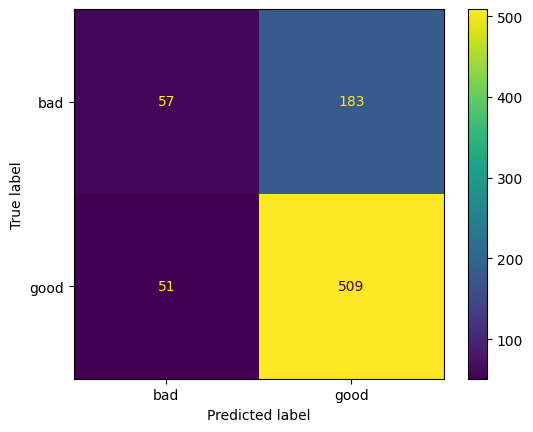

              precision    recall  f1-score   support

         bad       0.53      0.24      0.33       240
        good       0.74      0.91      0.81       560

    accuracy                           0.71       800
   macro avg       0.63      0.57      0.57       800
weighted avg       0.67      0.71      0.67       800


Test evaluation metrics:


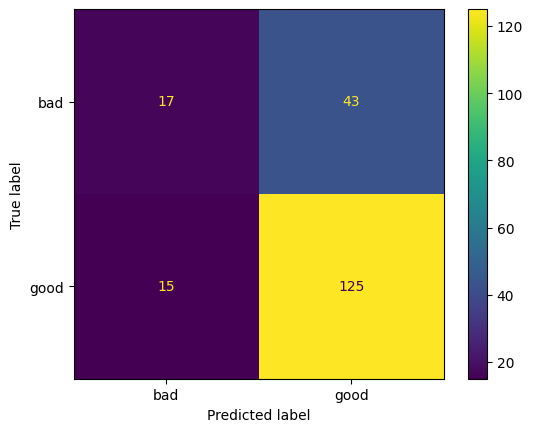

              precision    recall  f1-score   support

         bad       0.53      0.28      0.37        60
        good       0.74      0.89      0.81       140

    accuracy                           0.71       200
   macro avg       0.64      0.59      0.59       200
weighted avg       0.68      0.71      0.68       200



In [34]:
gnb = GaussianNB().fit(X_train, y_train)

# ============================================

print("\nTrain evaluation metrics:")

y_pred_train = gnb.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nTest evaluation metrics:")

y_pred_test = gnb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))


Train evaluation metrics:


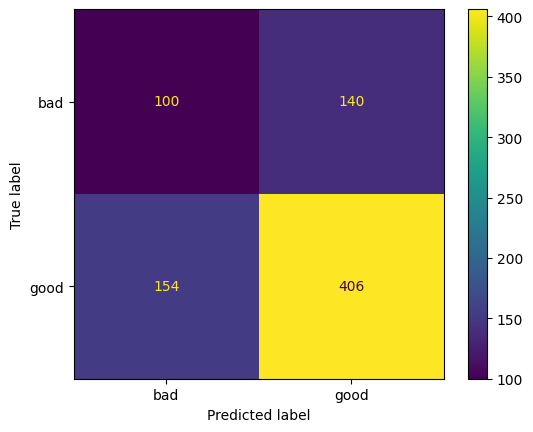

              precision    recall  f1-score   support

         bad       0.39      0.42      0.40       240
        good       0.74      0.72      0.73       560

    accuracy                           0.63       800
   macro avg       0.57      0.57      0.57       800
weighted avg       0.64      0.63      0.64       800


Test evaluation metrics:


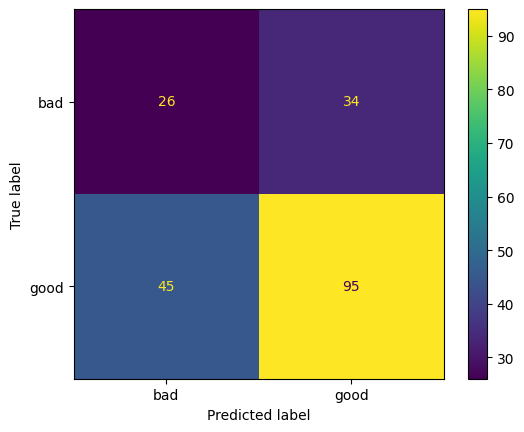

              precision    recall  f1-score   support

         bad       0.37      0.43      0.40        60
        good       0.74      0.68      0.71       140

    accuracy                           0.60       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.63      0.60      0.61       200



In [35]:
mnb = MultinomialNB().fit(X_train, y_train)

# ============================================

print("\nTrain evaluation metrics:")

y_pred_train = mnb.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nTest evaluation metrics:")

y_pred_test = mnb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))


Train evaluation metrics:


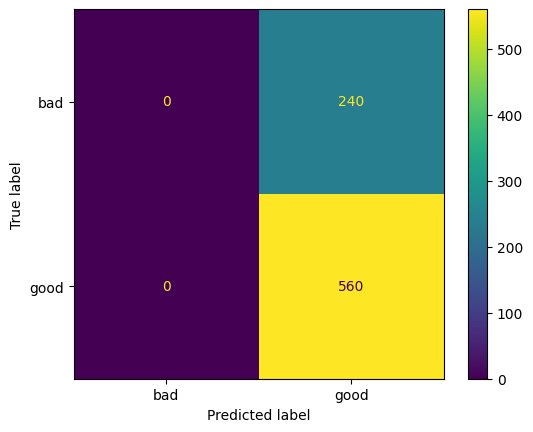

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00       240
        good       0.70      1.00      0.82       560

    accuracy                           0.70       800
   macro avg       0.35      0.50      0.41       800
weighted avg       0.49      0.70      0.58       800


Test evaluation metrics:


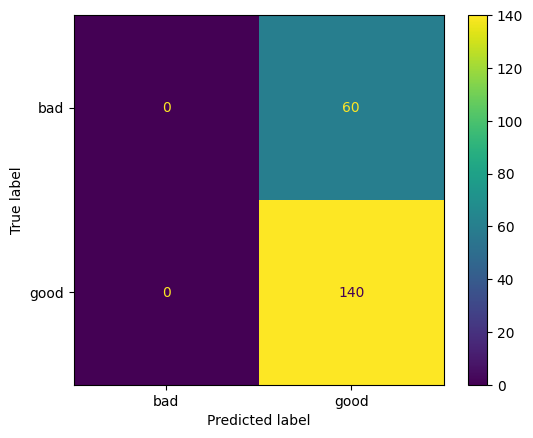

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00        60
        good       0.70      1.00      0.82       140

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



In [37]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB().fit(X_train, y_train)

# ============================================

print("\nTrain evaluation metrics:")

y_pred_train = bnb.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()
print(classification_report(y_train, y_pred_train))

# ============================================

print("\nTest evaluation metrics:")

y_pred_test = bnb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()
print(classification_report(y_test, y_pred_test))